# MultiGPU training on CIFAR-10

In this notebook we will train a wide residual network http://arxiv.org/abs/1605.07146 using multiple GPUs in a single machine. With minimal changes it achieves state-of-the-art on CIFAR-10, CIFAR-100 and SVHN.

We will use data parallelism to train the network.

You will need cudnn to run this notebook, which can be downloaded from https://developer.nvidia.com/cudnn, and NVIDIA NCCL library for efficient multiGPU communications https://github.com/NVIDIA/nccl
After, the following rocks are required:

```
luarocks install cudnn
luarocks install optnet
luarocks install nccl
```

In [1]:
cudnn = require 'cudnn'
cunn = require 'cunn'
optnet = require 'optnet'
tablex = require 'pl.tablex'
optim = require 'optim'

In [2]:
opt = {
    dataset = 'cifar10_original.t7',
    num_classes = 10,
    batchSize = 128,
    learningRate = 0.1,
    learningRateDecay = 0,
    learningRateDecayRatio = 0.2,
    weightDecay = 0.0005,
    dampening = 0,
    momentum = 0.9,
    epoch_step = {60,120,160},
    max_epoch = 200,
    optimMethod = 'sgd',
    nesterov = true,
    
    nGPU = 4,
    
    depth = 16,
    width = 4,
}

In [3]:
-- define wide residual network (WRN) model
function createModel(opt)
   local depth = opt.depth
   local width = opt.width
   
   -- define WRN basic block
   local function wide_basic(nInputPlane, nOutputPlane, stride)
      local nBottleneckPlane = nOutputPlane

      local block = nn.Sequential()
      local convs = nn.Sequential()     

      local module = nInputPlane == nOutputPlane and convs or block
      module:add(nn.SpatialBatchNormalization(nInputPlane))
      module:add(nn.ReLU(true))
      convs:add(nn.SpatialConvolution(nInputPlane,nBottleneckPlane,3,3,stride,stride,1,1):noBias())
      convs:add(nn.SpatialBatchNormalization(nBottleneckPlane))
      convs:add(nn.ReLU(true))
      convs:add(nn.SpatialConvolution(nBottleneckPlane,nBottleneckPlane,3,3,1,1,1,1):noBias())
      
      local shortcut = nInputPlane == nOutputPlane and
         nn.Identity() or
         nn.SpatialConvolution(nInputPlane,nOutputPlane,1,1,stride,stride,0,0):noBias()
     
      return block
         :add(nn.ConcatTable()
            :add(convs)
            :add(shortcut))
         :add(nn.CAddTable(true))
   end

   -- Stacking Residual Units on the same stage
   local function layer(block, nInputPlane, nOutputPlane, count, stride)
      local s = nn.Sequential()
      s:add(block(nInputPlane, nOutputPlane, stride))
      for i=2,count do
         s:add(block(nOutputPlane, nOutputPlane, 1))
      end
      return s
   end

   local model = nn.Sequential()
   do
      assert((depth - 4) % 6 == 0, 'depth should be 6n+4')
      local n = (depth - 4) / 6
      local k = width
      local nStages = torch.Tensor{16, 16*k, 32*k, 64*k} -- the difference between WRN and ResNet

      model:add(nn.SpatialConvolution(3,nStages[1],3,3,1,1,1,1)) -- one conv at the beginning (spatial size: 32x32)
      model:add(layer(wide_basic, nStages[1], nStages[2], n, 1)) -- Stage 1 (spatial size: 32x32)
      model:add(layer(wide_basic, nStages[2], nStages[3], n, 2)) -- Stage 2 (spatial size: 16x16)
      model:add(layer(wide_basic, nStages[3], nStages[4], n, 2)) -- Stage 3 (spatial size: 8x8)
      model:add(nn.SpatialBatchNormalization(nStages[4]))
      model:add(nn.ReLU(true))
      model:add(nn.SpatialAveragePooling(8, 8, 1, 1))
      model:add(nn.View(nStages[4]):setNumInputDims(3))
      model:add(nn.Linear(nStages[4], opt.num_classes))
   end

    -- init from He etal
    local function MSRinit(model)
       for k,v in pairs(model:findModules('nn.SpatialConvolution')) do
          local n = v.kW*v.kH*v.nOutputPlane
          v.weight:normal(0,math.sqrt(2/n))
          if v.bias then v.bias:zero() end
       end
    end

    local function FCinit(model)
       for k,v in pairs(model:findModules'nn.Linear') do
         v.bias:zero()
       end
    end
    
   MSRinit(model)
   FCinit(model)

   return model
end

-- define base network that will be used inside DataParallelTable
net = createModel(opt):float()

Alright, we now defined some complicated model, can we visuailze it's structure? Yes, and we will use optnet to do so:

In [4]:
graphgen = require 'optnet.graphgen'

-- optnet needs to propagate through the network to generate the graph
-- so we create a dummy input for it
local input = torch.randn(1,3,32,32):float()

-- we will generate svg image from our graph
local svgname = paths.tmpname() .. '.svg'
graph.graphvizFile(graphgen(net,input), 'dot', svgname)
itorch.svg(svgname)

Torch makes data parallelism very easy, essentially the difference within single GPU is 6 lines in the end of this cell:

In [7]:
-- this iterates over the network and replaces `nn` modules with their
-- cudnn counterparts in-place
cudnn.convert(net, cudnn):cuda()

-- utilize optnet to reduce memory usage
-- it needs a sample input to call forward propagation and track tensors
-- internally it tracks tensor life times and shares non overlapping storages
local sample_input = torch.randn(8,3,32,32):cuda()
optnet.optimizeMemory(net, sample_input, {inplace = false, mode = 'training'})

-- with this cudnn will optimize itself for efficientl
cudnn.benchmark = true

-- on input we will have 'byte' type, and will normalize it to [0,1] range
model = nn.Sequential()
    :add(nn.Copy('torch.ByteTensor', 'torch.CudaTensor'))
    :add(nn.Mul(1/256))
    :cuda()
if opt.nGPU == 1 then
    model:add(net)
else
    -- this will wrap our initial network into data parallel module
    -- that will take care around multi-GPU communications in an efficient
    -- manner, and will launch CUDA kernels in parallel to reduce overhead on
    -- kernel launches
    -- DataParallelTable will simply split the input tensor in parts and each GPU will
    -- execute it's own part
    local gpus = torch.range(1, opt.nGPU):totable()
    model:add(nn.DataParallelTable(1, true, true)
         :add(net, gpus)
         :threads(function()
            local cudnn = require 'cudnn'
            cudnn.benchmark = true
         end))
end

Skipping memory optimization. Network is already optimized for training mode.	


We will now donwload CIFAR-10 dataset in torch 'byte' tensor format, packed with train and test subsets

In [8]:
provider = torch.load(opt.dataset)
print(provider)

{
  trainData : 
    {
      data : ByteTensor - size: 50000x3x32x32
      size : function: 0x40c84848
      labels : ByteTensor - size: 50000
    }
  testData : 
    {
      data : ByteTensor - size: 10000x3x32x32
      size : function: 0x40ee8e08
      labels : ByteTensor - size: 10000
    }
}


Let's take a look at a few examples from the dataset

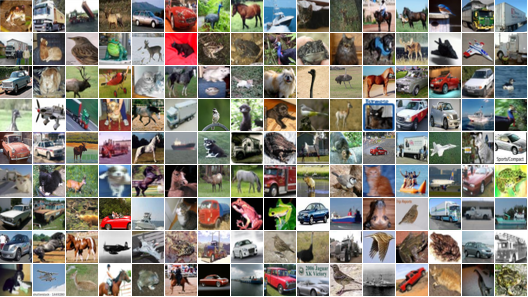

In [9]:
itorch.image(image.toDisplayTensor{input=provider.trainData.data:narrow(1,1,144), nrow=16, padding=1})

This function should not be called more that once per model. Although it's called `getParameters`, it modifies the sctucture of the network. It takes all weights and biases over the network and creates one large contiguous tensor, and makes weights and biases point into the parts of this network. This reduces overhead on optimization calles, and is in particular useful for multi-GPU, as nccl can make use of it to optimize memory transfers over different cards.

In [10]:
parameters,gradParameters = model:getParameters()

In [11]:
local criterion = nn.CrossEntropyCriterion():cuda()

-- a-la autograd
local f = function(inputs, targets)
   model:forward(inputs)
   local loss = criterion:forward(model.output, targets)
   local df_do = criterion:backward(model.output, targets)
   model:backward(inputs, df_do)
   return loss
end

local optimState = tablex.deepcopy(opt)


function train()
  model:training()

  local targets = torch.CudaTensor(opt.batchSize)
  local indices = torch.randperm(provider.trainData.data:size(1)):long():split(opt.batchSize)
  -- remove last element so that all minibatches have equal size
  indices[#indices] = nil

  local loss = 0

  for t,v in ipairs(indices) do
    local inputs = provider.trainData.data:index(1,v)
    targets:copy(provider.trainData.labels:index(1,v))

    optim[opt.optimMethod](function(x)
      if x ~= parameters then parameters:copy(x) end
      model:zeroGradParameters()
      loss = loss + f(inputs, targets)
      return f,gradParameters
    end, parameters, optimState)
  end

  return loss / #indices
end

function test(verbose)
  model:evaluate()
  local confusion = optim.ConfusionMatrix(opt.num_classes)
  local data_split = provider.testData.data:split(opt.batchSize,1)
  local labels_split = provider.testData.labels:split(opt.batchSize,1)

  for i,v in ipairs(data_split) do
    confusion:batchAdd(model:forward(v), labels_split[i])
  end

  confusion:updateValids()
  if verbose then print(tostring(confusion)) end
  return confusion.totalValid * 100
end

In [12]:
train_loss = {}
val_accs = {}
for epoch=1,opt.max_epoch do
    -- drop learning rate and reset momentum vector
    if torch.type(opt.epoch_step) == 'number' and epoch % opt.epoch_step == 0 or
       torch.type(opt.epoch_step) == 'table' and tablex.find(opt.epoch_step, epoch) then
        opt.learningRate = opt.learningRate * opt.learningRateDecayRatio
        optimState = tablex.deepcopy(opt)
    end
    
    train_loss[epoch] = train()
    val_accs[epoch] = test()
    print('Epoch: '.. epoch .. ', loss:' .. train_loss[epoch] .. ', val accuracy: ' .. val_accs[epoch])
end

-- print confusion matrix
print(test(true))

Epoch: 	1	, loss:	1.3838073334633	, val accuracy: 	59.35	


Epoch: 	2	, loss:	0.8794117803757	, val accuracy: 	67.02	


Epoch: 	3	, loss:	0.68406125398783	, val accuracy: 	66.59	


Epoch: 	4	, loss:	0.59208497259861	, val accuracy: 	68.28	


Epoch: 	

5	, loss:	0.52364288988786	, val accuracy: 	76.4	


Epoch: 	6	, loss:	0.47224203134194	, val accuracy: 	76.21	


Epoch: 	7	, loss:	0.43413377595253	, val accuracy: 	69.45	


Epoch: 	8	, loss:	0.40561517224862	, val accuracy: 	78.36	


Epoch: 	9	, loss:	0.37748653300298	, val accuracy: 	68.71	


Epoch: 	10	, loss:	0.35970024737792	, val accuracy: 	77.63	


Epoch: 	11	, loss:	0.33688636032435	, val accuracy: 	82.64	


Epoch: 	12	, loss:	0.32155594057762	, val accuracy: 	74.5	


Epoch: 	13	, loss:	0.42819119420571	, val accuracy: 	76.8	


In [ ]:
test()